CODE BLOCK: 1

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/ERA/Session_9/")

In [3]:
# !pip install -U albumentations


In [4]:
from utils import *
from transform import *
from models import *
from dataset import *

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

CODE BLOCK: 2

In [6]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CUDA Available? True
cuda


CODE BLOCK: 4

In [7]:



train_data = cifarDataset('../data', train=True, download=True, transform=train_transforms_A)
test_data = cifarDataset('../data', train=False, download=True, transform=test_transforms_A)


Files already downloaded and verified
Files already downloaded and verified


In [8]:

# train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
# test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)


CODE BLOCK: 5

In [9]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CODE BLOCK: 6

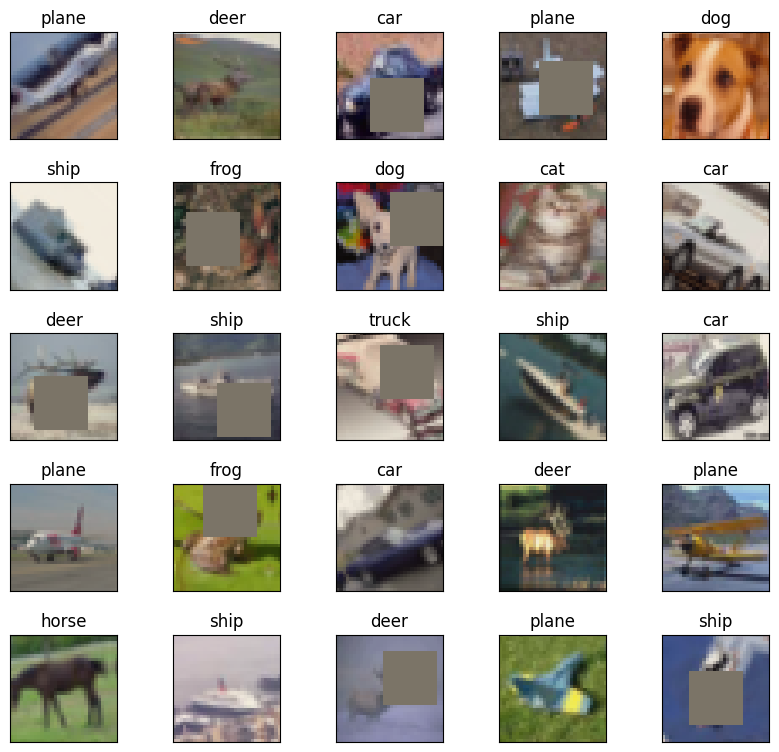

In [10]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))
plot_samples_cifar10(batch_data,batch_label,classes, denormalise = True)

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = s9_model_1().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 32, 31, 31]          16,416
              ReLU-8           [-1, 32, 31, 31]               0
       BatchNorm2d-9           [-1, 32, 31, 31]              64
           Conv2d-10           [-1, 32, 31, 31]           9,248
             ReLU-11           [-1, 32, 31, 31]               0
      BatchNorm2d-12           [-1, 32, 31, 31]              64
           Conv2d-13           [-1, 16, 31, 31]             528
           Conv2d-14           [-1, 64,

CODE BLOCK: 8

In [12]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [13]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            # loss_fn = nn.CrossEntropyLoss(reduction='sum')
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [14]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
# criterion = nn.CrossEntropyLoss()
num_epochs = 50

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  # scheduler.step()

Epoch 1


Train: Loss=1.6278 Batch_id=97 Accuracy=25.46: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]


Test set: Average loss: 1.7196, Accuracy: 3578/10000 (35.78%)

Epoch 2


Train: Loss=1.6034 Batch_id=97 Accuracy=38.84: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]


Test set: Average loss: 1.4885, Accuracy: 4533/10000 (45.33%)

Epoch 3


Train: Loss=1.3536 Batch_id=97 Accuracy=45.09: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]


Test set: Average loss: 1.2969, Accuracy: 5237/10000 (52.37%)

Epoch 4


Train: Loss=1.3020 Batch_id=97 Accuracy=49.44: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]


Test set: Average loss: 1.2300, Accuracy: 5522/10000 (55.22%)

Epoch 5


Train: Loss=1.3083 Batch_id=97 Accuracy=52.53: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]


Test set: Average loss: 1.1310, Accuracy: 5968/10000 (59.68%)

Epoch 6


Train: Loss=1.2000 Batch_id=97 Accuracy=55.65: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s]


Test set: Average loss: 1.0125, Accuracy: 6378/10000 (63.78%)

Epoch 7


Train: Loss=1.2606 Batch_id=97 Accuracy=57.73: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]


Test set: Average loss: 1.0103, Accuracy: 6438/10000 (64.38%)

Epoch 8


Train: Loss=1.1780 Batch_id=97 Accuracy=59.17: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]


Test set: Average loss: 0.9585, Accuracy: 6551/10000 (65.51%)

Epoch 9


Train: Loss=1.1471 Batch_id=97 Accuracy=61.01: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]


Test set: Average loss: 0.9816, Accuracy: 6583/10000 (65.83%)

Epoch 10


Train: Loss=1.0588 Batch_id=97 Accuracy=63.02: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]


Test set: Average loss: 0.9425, Accuracy: 6635/10000 (66.35%)

Epoch 11


Train: Loss=1.0844 Batch_id=97 Accuracy=63.97: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]


Test set: Average loss: 0.8913, Accuracy: 6902/10000 (69.02%)

Epoch 12


Train: Loss=1.0261 Batch_id=97 Accuracy=64.87: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]


Test set: Average loss: 0.7805, Accuracy: 7277/10000 (72.77%)

Epoch 13


Train: Loss=0.9317 Batch_id=97 Accuracy=66.03: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 0.7595, Accuracy: 7363/10000 (73.63%)

Epoch 14


Train: Loss=0.9791 Batch_id=97 Accuracy=67.02: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]


Test set: Average loss: 0.8180, Accuracy: 7117/10000 (71.17%)

Epoch 15


Train: Loss=0.9340 Batch_id=97 Accuracy=67.73: 100%|██████████| 98/98 [00:20<00:00,  4.90it/s]


Test set: Average loss: 0.7688, Accuracy: 7351/10000 (73.51%)

Epoch 16


Train: Loss=0.9127 Batch_id=97 Accuracy=68.38: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]


Test set: Average loss: 0.7277, Accuracy: 7467/10000 (74.67%)

Epoch 17


Train: Loss=0.8669 Batch_id=97 Accuracy=69.45: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]


Test set: Average loss: 0.6767, Accuracy: 7702/10000 (77.02%)

Epoch 18


Train: Loss=0.8178 Batch_id=97 Accuracy=69.71: 100%|██████████| 98/98 [00:20<00:00,  4.77it/s]


Test set: Average loss: 0.6685, Accuracy: 7691/10000 (76.91%)

Epoch 19


Train: Loss=0.7756 Batch_id=97 Accuracy=70.40: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]


Test set: Average loss: 0.6525, Accuracy: 7727/10000 (77.27%)

Epoch 20


Train: Loss=0.8024 Batch_id=97 Accuracy=70.70: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]


Test set: Average loss: 0.6365, Accuracy: 7797/10000 (77.97%)

Epoch 21


Train: Loss=0.8050 Batch_id=97 Accuracy=71.25: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]


Test set: Average loss: 0.6784, Accuracy: 7663/10000 (76.63%)

Epoch 22


Train: Loss=0.8307 Batch_id=97 Accuracy=71.54: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]


Test set: Average loss: 0.6486, Accuracy: 7815/10000 (78.15%)

Epoch 23


Train: Loss=0.8217 Batch_id=97 Accuracy=71.98: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Test set: Average loss: 0.5946, Accuracy: 7936/10000 (79.36%)

Epoch 24


Train: Loss=0.9226 Batch_id=97 Accuracy=72.38: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]


Test set: Average loss: 0.6699, Accuracy: 7742/10000 (77.42%)

Epoch 25


Train: Loss=0.8208 Batch_id=97 Accuracy=72.91: 100%|██████████| 98/98 [00:20<00:00,  4.88it/s]


Test set: Average loss: 0.6012, Accuracy: 7932/10000 (79.32%)

Epoch 26


Train: Loss=0.8026 Batch_id=97 Accuracy=73.28: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]


Test set: Average loss: 0.6018, Accuracy: 7923/10000 (79.23%)

Epoch 27


Train: Loss=0.8815 Batch_id=97 Accuracy=73.44: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]


Test set: Average loss: 0.5751, Accuracy: 8034/10000 (80.34%)

Epoch 28


Train: Loss=0.7492 Batch_id=97 Accuracy=73.60: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]


Test set: Average loss: 0.5658, Accuracy: 8071/10000 (80.71%)

Epoch 29


Train: Loss=0.7284 Batch_id=97 Accuracy=74.27: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]


Test set: Average loss: 0.5992, Accuracy: 7966/10000 (79.66%)

Epoch 30


Train: Loss=0.6653 Batch_id=97 Accuracy=74.18: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]


Test set: Average loss: 0.6010, Accuracy: 7914/10000 (79.14%)

Epoch 31


Train: Loss=0.6343 Batch_id=97 Accuracy=74.60: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s]


Test set: Average loss: 0.5783, Accuracy: 8018/10000 (80.18%)

Epoch 32


Train: Loss=0.8204 Batch_id=97 Accuracy=75.15: 100%|██████████| 98/98 [00:19<00:00,  4.91it/s]


Test set: Average loss: 0.5494, Accuracy: 8072/10000 (80.72%)

Epoch 33


Train: Loss=0.7556 Batch_id=97 Accuracy=75.01: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]


Test set: Average loss: 0.5718, Accuracy: 8072/10000 (80.72%)

Epoch 34


Train: Loss=0.6806 Batch_id=97 Accuracy=75.34: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s]


Test set: Average loss: 0.5416, Accuracy: 8145/10000 (81.45%)

Epoch 35


Train: Loss=0.6422 Batch_id=97 Accuracy=75.42: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]


Test set: Average loss: 0.5838, Accuracy: 8058/10000 (80.58%)

Epoch 36


Train: Loss=0.6763 Batch_id=97 Accuracy=75.75: 100%|██████████| 98/98 [00:19<00:00,  4.90it/s]


Test set: Average loss: 0.5138, Accuracy: 8203/10000 (82.03%)

Epoch 37


Train: Loss=0.6232 Batch_id=97 Accuracy=75.68: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]


Test set: Average loss: 0.5116, Accuracy: 8276/10000 (82.76%)

Epoch 38


Train: Loss=0.6473 Batch_id=97 Accuracy=75.95: 100%|██████████| 98/98 [00:19<00:00,  4.90it/s]


Test set: Average loss: 0.5293, Accuracy: 8194/10000 (81.94%)

Epoch 39


Train: Loss=0.5395 Batch_id=97 Accuracy=76.35: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]


Test set: Average loss: 0.5040, Accuracy: 8271/10000 (82.71%)

Epoch 40


Train: Loss=0.6907 Batch_id=97 Accuracy=76.50: 100%|██████████| 98/98 [00:19<00:00,  4.90it/s]


Test set: Average loss: 0.5008, Accuracy: 8293/10000 (82.93%)

Epoch 41


Train: Loss=0.7529 Batch_id=97 Accuracy=76.75: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]


Test set: Average loss: 0.5368, Accuracy: 8191/10000 (81.91%)

Epoch 42


Train: Loss=0.6824 Batch_id=97 Accuracy=76.78: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s]


Test set: Average loss: 0.4943, Accuracy: 8281/10000 (82.81%)

Epoch 43


Train: Loss=0.5948 Batch_id=97 Accuracy=77.02: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]


Test set: Average loss: 0.4871, Accuracy: 8337/10000 (83.37%)

Epoch 44


Train: Loss=0.6725 Batch_id=97 Accuracy=77.32: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]


Test set: Average loss: 0.5040, Accuracy: 8285/10000 (82.85%)

Epoch 45


Train: Loss=0.6766 Batch_id=97 Accuracy=77.42: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]


Test set: Average loss: 0.4829, Accuracy: 8331/10000 (83.31%)

Epoch 46


Train: Loss=0.6746 Batch_id=97 Accuracy=76.99: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]


Test set: Average loss: 0.4926, Accuracy: 8305/10000 (83.05%)

Epoch 47


Train: Loss=0.6819 Batch_id=97 Accuracy=77.65: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]


Test set: Average loss: 0.5169, Accuracy: 8272/10000 (82.72%)

Epoch 48


Train: Loss=0.6241 Batch_id=97 Accuracy=77.86: 100%|██████████| 98/98 [00:20<00:00,  4.88it/s]


Test set: Average loss: 0.4948, Accuracy: 8335/10000 (83.35%)

Epoch 49


Train: Loss=0.5687 Batch_id=97 Accuracy=78.15: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]


Test set: Average loss: 0.4882, Accuracy: 8331/10000 (83.31%)

Epoch 50


Train: Loss=0.7021 Batch_id=97 Accuracy=78.17: 100%|██████████| 98/98 [00:20<00:00,  4.88it/s]


Test set: Average loss: 0.5077, Accuracy: 8302/10000 (83.02%)



CODE BLOCK: 11

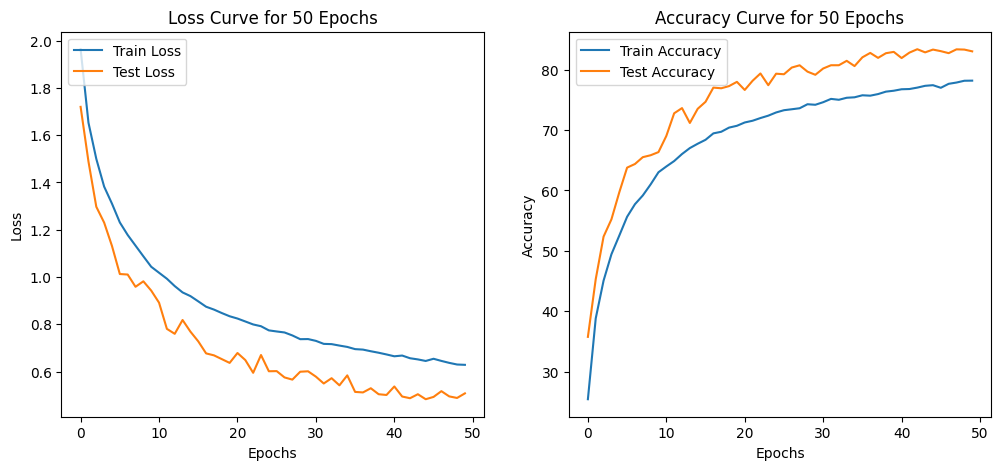

In [15]:
plot_accuracy_metrics(train_losses,train_acc,test_losses,test_acc,num_epochs)

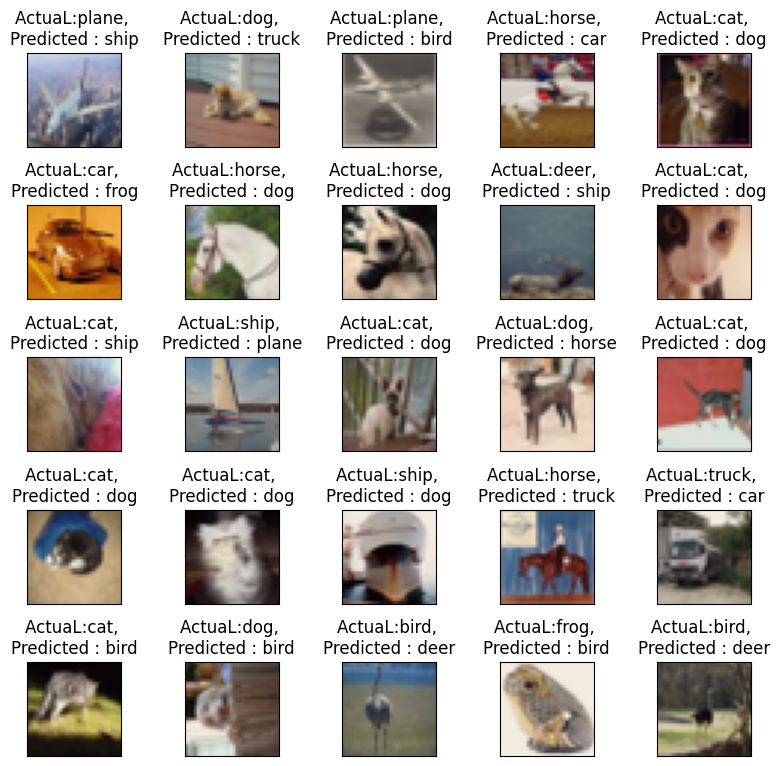

In [16]:
# Show Misclassified images
for batch_idx, (data, target) in enumerate(test_loader):
  data, target = data.to(device), target.to(device)
  output = model(data)
  output_label = output.argmax(dim=1)
  op_ne_target = output.argmax(dim=1).ne(target)
  actual_label = target[op_ne_target].to('cpu')
  predicted_label = output_label[op_ne_target].to('cpu')
  images = data[op_ne_target].to('cpu')
  plot_misclassified_samples(images, actual_label, predicted_label,classes,unorm)
  break
